## Code Documentation

This code performs bayesian analysis on the bayesian model results.

#### Libraries and Modules

The code imports the following libraries and modules:

In [1]:
# Import the necessary libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az
from utils.metrics import calculate_metrics, confidence_interval
from utils.Plots import predictions_with_uncertainty
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
training_set = pd.read_csv("datasets/training_set.csv", index_col=0)
validation_set = pd.read_csv("datasets/validation_set.csv", index_col=0)
test_set = pd.read_csv("datasets/test_set_preprocessed.csv", index_col = 0)

df_X_train = training_set.drop('label', axis=1)
y_train = training_set['label']
df_X_val = validation_set.drop('label', axis=1)
y_val = validation_set['label']
df_X_test = test_set.drop('label', axis=1)
y_test = test_set['label']

#### Loading the prior and posterior results

In [3]:
#Priors
#logistic_prior = pd.read_csv("results/bayesian_results/logistic_prior_samples.csv")
#logistic_prior = pd.read_csv("results/bayesian_results/lasso_prior_samples.csv")
#logistic_prior = pd.read_csv("results/bayesian_results/esnet_prior_samples.csv")
logistic_prior = pd.read_csv("results/bayesian_results/rhs_prior_samples.csv")

#Posteriors
#logistic = pd.read_csv("results/bayesian_results/logistic_posterior_samples.csv")
#logistic = pd.read_csv("results/bayesian_results/lasso_posterior_samples.csv")
#logistic = pd.read_csv("results/bayesian_results/esnet_posterior_samples.csv")
logistic = pd.read_csv("results/bayesian_results/rhs_posterior_samples.csv")

#### Prior and posterior estimates

In [4]:
alpha_values_prior = logistic_prior["alpha"].mean()
beta_values_prior = logistic_prior.loc[:,'beta.1':'beta.763']

alpha_values_posterior = logistic['alpha']
beta_values_posterior = logistic.loc[:,'beta.1':'beta.763']

#### Extract the prior and posterior predictive distributions

In [5]:
logistic_prior_pred_dist = pd.DataFrame(logistic_prior[[col for col in logistic_prior.columns if "y_pred" in col]])
logistic_pred_train_dist = pd.DataFrame(logistic[[col for col in logistic.columns if "y_train_pred" in col]])
logistic_val_dist = pd.DataFrame(logistic[[col for col in logistic.columns if "y_val_pred" in col]])

#### Predict for the test set

In [6]:
logistic_test_dist = np.zeros((20000, 190))

for i in range(20000):
    # Calculate the linear combination of inputs and weights
    linear_predictor = np.dot(df_X_test, beta_values_posterior.loc[i, :].T) + alpha_values_posterior[i]
    # Apply the logistic function to convert these values into probabilities
    logistic_test_dist[i, :] = 1 / (1 + np.exp(-linear_predictor))

logistic_test_dist = pd.DataFrame(logistic_test_dist)
logistic_test_dist.columns = ['y_test.' + str(i+1) for i in range(190)]

C:\Users\ravindranth\AppData\Local\Temp\ipykernel_29648\1804439649.py:7: RuntimeWarning: overflow encountered in exp
  logistic_test_dist[i, :] = 1 / (1 + np.exp(-linear_predictor))


#### Calculating the Latent variable prior and posterior distributions

In [7]:
pr_alpha = alpha_values_prior.mean()
pr_beta_values = beta_values_prior.mean()
y_latent_pr = np.dot(df_X_train, pr_beta_values) + pr_alpha
pos_alpha = alpha_values_posterior.mean()
pos_beta_values = beta_values_posterior.mean()
y_latent_pos = np.dot(df_X_train, pos_beta_values) + pos_alpha

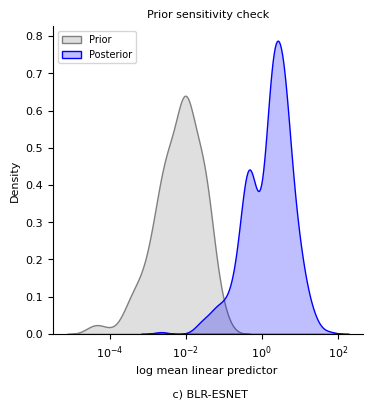

In [8]:
plt.figure(figsize=(4,4))
sns.kdeplot(y_latent_pr, label="Prior", color='grey', fill=True, log_scale=True)
sns.kdeplot(y_latent_pos, label="Posterior", color='blue', fill=True, log_scale=True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylabel("Density", fontdict={"fontsize":8})
plt.xlabel("log mean linear predictor \n \n c) BLR-ESNET", fontdict={"fontsize":8})
plt.legend(loc = "upper left", fontsize = 7)
plt.title("Prior sensitivity check",fontdict={"fontsize":8})
#plt.savefig("plots/linear_predictors_ESNET.pdf", bbox_inches = "tight", dpi = 2000)
plt.show()

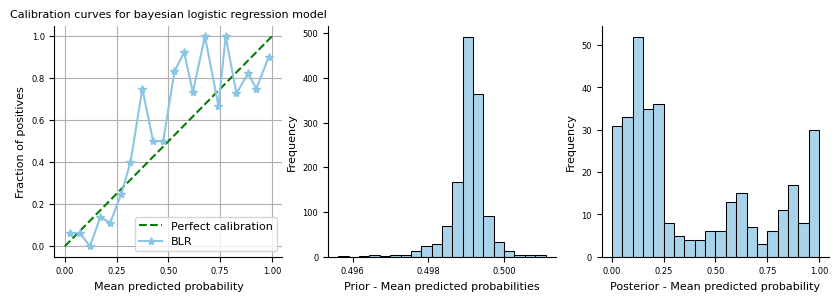

In [9]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, logistic_val_dist.mean(), n_bins=20)

plt.figure(figsize=(10, 3))

plt.subplot(1,3,1)
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect calibration", color='green')
plt.plot(mean_predicted_value, fraction_of_positives, marker='*', label="BLR", color='#8cc5e3')
plt.xlabel("Mean predicted probability", fontsize=8)
plt.ylabel("Fraction of positives", fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title("Calibration curves for bayesian logistic regression model", fontsize=8)

plt.subplot(1,3,2)
sns.histplot(np.array(logistic_prior_pred_dist.mean()), color='#8cc5e3', fill=True, bins = 20)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.xlabel("Prior - Mean predicted probabilities", fontsize=8)
plt.ylabel("Frequency", fontsize=8)

plt.subplot(1,3,3)
sns.histplot(np.array(logistic_val_dist.mean()), color='#8cc5e3', fill=True, bins=20)
plt.xlabel("Posterior - Mean predicted probability", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

#### Training and validation predictive uncertainty

#### Validation predictive uncertainty

C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = mean[sort]
C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = std[sort]


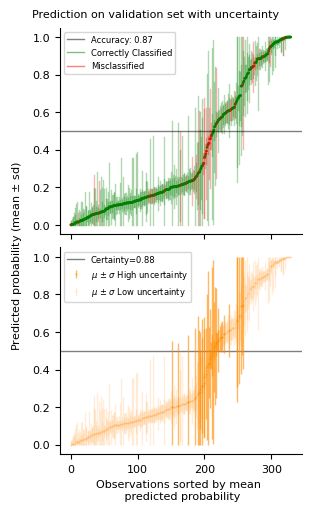

In [10]:
valid_uncertainty = predictions_with_uncertainty(logistic_val_dist, y_val, method = "BLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on validation set with uncertainty",
                                          use_quantile=False)
#valid_uncertainty.savefig("plots/blresnet_val_uncertain.pdf", dpi = 2000, bbox_inches="tight")
valid_uncertainty.show()

C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = mean[sort]
C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = std[sort]


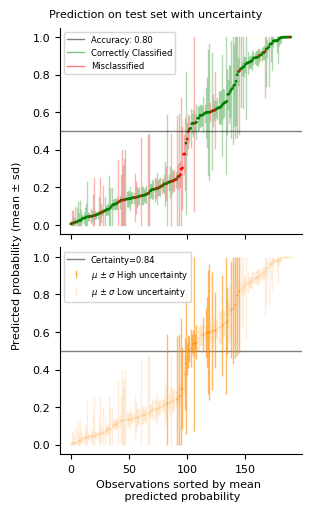

In [11]:
test_uncertainty = predictions_with_uncertainty(logistic_test_dist, y_test, method = "BLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on test set with uncertainty",
                                          use_quantile=False)
#test_uncertainty.savefig("plots/blresnet_test_uncertain.pdf", dpi = 2000, bbox_inches="tight")
test_uncertainty.show()

In [12]:
# Define the samples length
n_samples = len(alpha_values_posterior)
df_train_pred = logistic_pred_train_dist.T
df_val_pred = logistic_val_dist.T
df_test_pred = logistic_test_dist.T

In [13]:
# Initialize lists to store metrics
metrics_train, metrics_val, metrics_test = [], [], []

for i in range(n_samples):
    # Calculate metrics for training data
    metrics_train.append(calculate_metrics(y_train, df_train_pred.iloc[:, i]))
    
    # Calculate metrics for validation data
    metrics_val.append(calculate_metrics(y_val, df_val_pred.iloc[:, i]))
    
    # Calculate metrics for testing data
    metrics_test.append(calculate_metrics(y_test, df_test_pred.iloc[:, i]))

# Convert lists to DataFrames
metrics_train_df = pd.DataFrame(metrics_train, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])
metrics_val_df = pd.DataFrame(metrics_val, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])
metrics_test_df = pd.DataFrame(metrics_test, columns=['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv'])

In [14]:
dfs = []

# For each metric
for metric in ['sens', 'spec', 'auc', 'acc', 'f1', 'logloss', 'ppv', 'npv']:
    results = {}
    for dataset in ['train', 'val', 'test']:
        ci_lower, mean, ci_upper = confidence_interval(eval(f'metrics_{dataset}_df')[metric])
        results[f'{dataset} mean'] = mean
        results[f'{dataset} 95% CI'] = f'[{ci_lower}, {ci_upper}]'
    dfs.append(pd.DataFrame(results, index=[metric]))

# Concatenate the DataFrames
df_results = pd.concat(dfs)
df_results.index = [
    'Sensitivity', 'Specificity', 'AUC', 'Accuracy', 
    'F1 Score', 'Log Loss', 'PPV', 'NPV'
]
df_results.columns = [
    "training", "training 95% CI", "validation", "validation 95% CI", 
    "testing", "testing 95% CI"
]

# Display the results
df_results

,training,training 95% CI,validation,validation 95% CI,testing,testing 95% CI
Sensitivity,0.8093,"[0.7566, 0.8519]",0.7690,"[0.7073, 0.8211]",0.6928,"[0.6273, 0.7545]"
Specificity,0.9245,"[0.9114, 0.9381]",0.8864,"[0.8599, 0.9082]",0.8954,"[0.8625, 0.925]"
AUC,0.9356,"[0.9276, 0.9432]",0.8660,"[0.8383, 0.8899]",0.8164,"[0.7765, 0.8528]"
Accuracy,0.8814,"[0.8648, 0.8952]",0.8427,"[0.8182, 0.8636]",0.7781,"[0.7368, 0.8158]"
F1 Score,0.8361,"[0.8074, 0.8583]",0.7845,"[0.7436, 0.8178]",0.7829,"[0.734, 0.8235]"
Log Loss,0.3461,"[0.3271, 0.3657]",0.7708,"[0.562, 1.0571]",1.3362,"[0.891, 1.8142]"
PPV,0.8652,"[0.8474, 0.8831]",0.8011,"[0.7652, 0.8333]",0.9011,"[0.8706, 0.9294]"
NPV,0.8904,"[0.8643, 0.9117]",0.8662,"[0.8356, 0.8916]",0.6802,"[0.6339, 0.7228]"


#### Find 95% Credible interval significant features
* Finding the features whose coefficients confidence interval doesn't include 0

In [15]:
coefficients = logistic.loc[:,'beta.1':'beta.763']
coefficients["alpha"] = logistic['alpha']
summary_coef = coefficients.describe(percentiles=[0.025,0.25, 0.5, 0.75, 0.975]).T

In [16]:
extracted_features = []
beta_coefficients = []
for beta_name in summary_coef.index:
    lower = summary_coef.loc[beta_name, '2.5%']
    upper = summary_coef.loc[beta_name, '97.5%']
    if not (lower <= 0 <= upper) and beta_name != "alpha":
        extracted_features.append(int(beta_name.split('.')[1]))
        beta_coefficients.append(beta_name)

In [17]:
imp_features = df_X_train.columns[list(np.array(extracted_features) - 1)]
imp_features_coef = logistic.loc[:,beta_coefficients]
imp_features_coef.columns = imp_features

### Visualising the distribution of coefficients

In [18]:
beta_coefficients

['beta.50', 'beta.57', 'beta.139']

In [19]:
logistic_summary = logistic.loc[:,beta_coefficients].T
logistic_summary = logistic_summary.set_index(imp_features)

feat_dict = {}
for i, row in logistic_summary.iterrows():
    feat_dict[i] = list(np.array(logistic_summary.loc[i,:]))

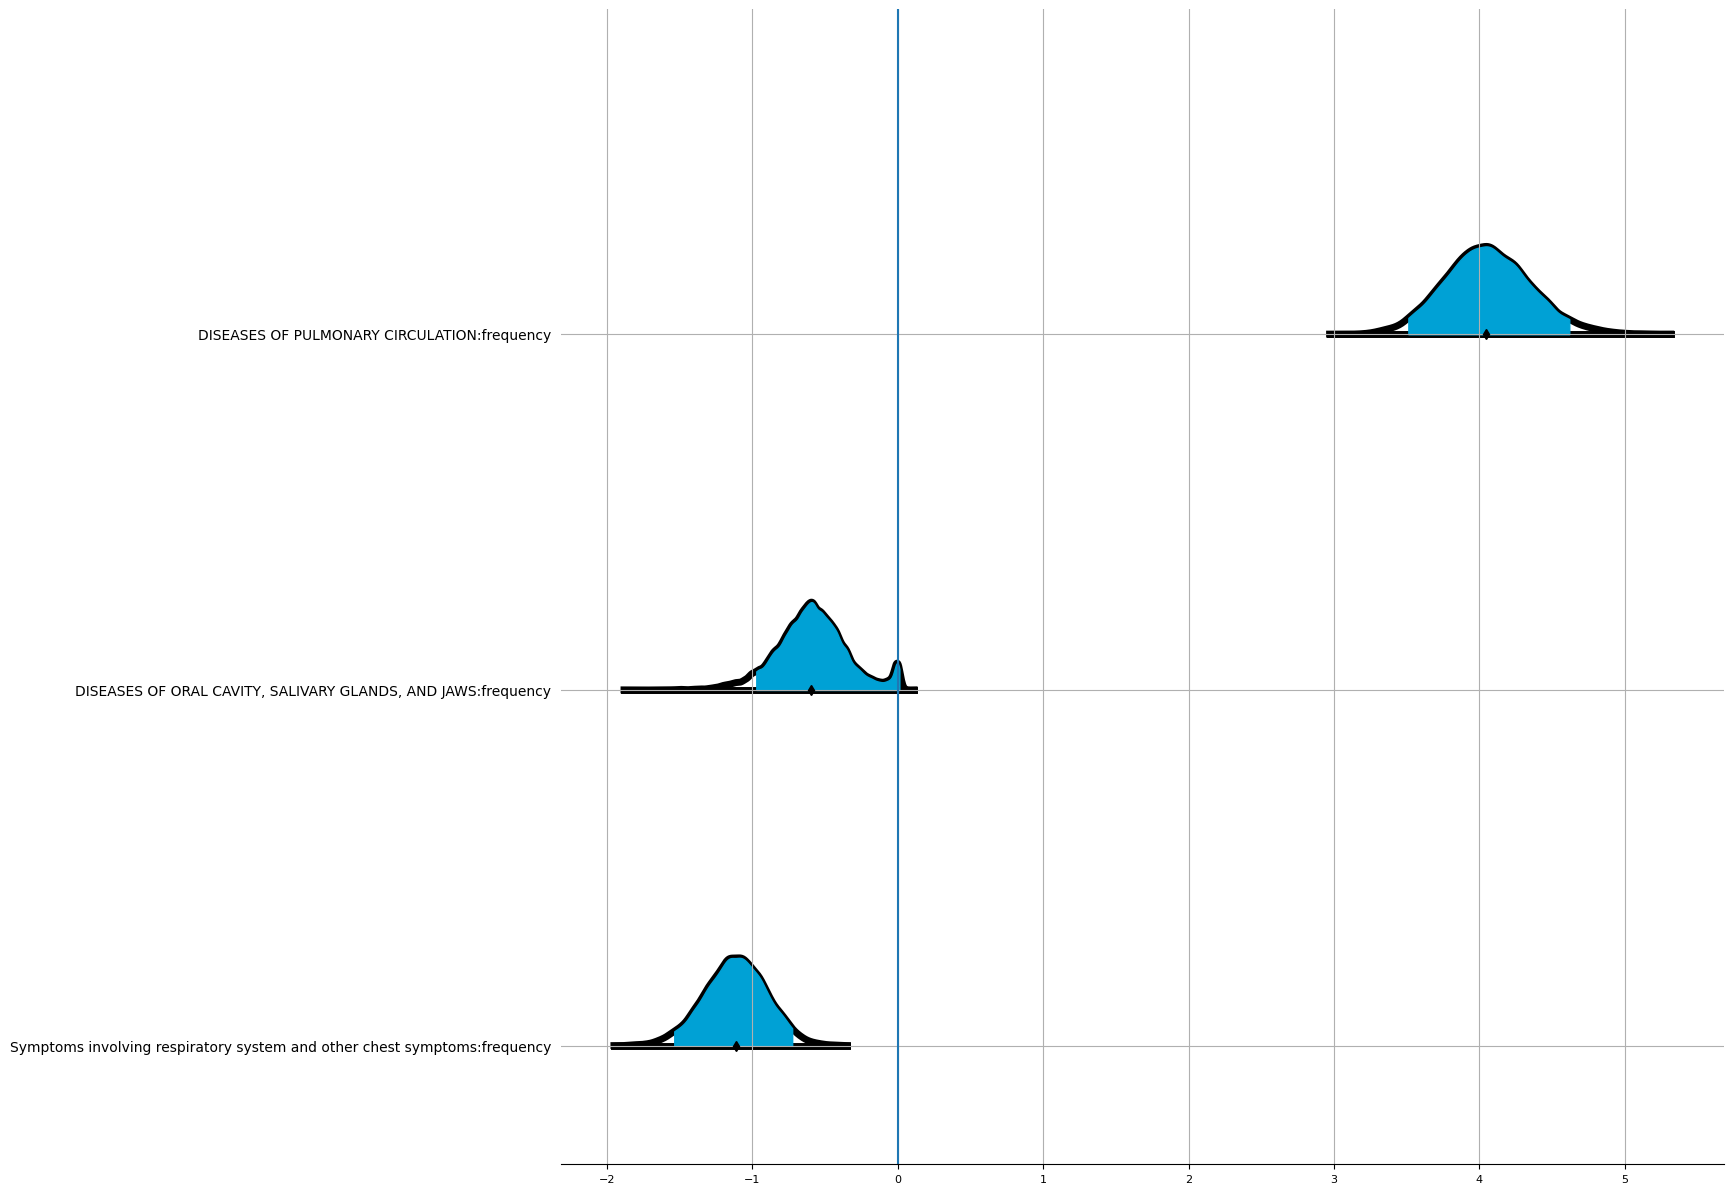

In [20]:
az.plot_forest(
        feat_dict,
        linewidth= 5,
        markersize=5,
        kind="ridgeplot",
        combined=True,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.5],
        ridgeplot_overlap=1,
        colors="#00A1D5FF",
        figsize=(15, 15))
plt.grid()
plt.axvline(x=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=8)
plt.gca().spines["right"].set_color("none")
plt.gca().spines["top"].set_color("none")
#plt.savefig("results/ehr/lasso_features_distributions.png", bbox_inches="tight")